In [1]:
import pickle
import numpy as np
import tensorflow as tf
import os

# Get the data
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


def get_data(file_path, first_class, second_class):
    
    unpickled_file = unpickle(file_path)
    inputs = unpickled_file[b'data']
    labels = unpickled_file[b'labels']
    
    # Extract inputs and labels only in the first and the second class
    labels = np.array(labels)
    new_inputs = inputs[np.array([i for i in range(len(labels)) if labels[i] == first_class or labels[i] == second_class]),] 
    new_labels = labels[np.array([i for i in range(len(labels)) if labels[i] == first_class or labels[i] == second_class])]
    
    # Change the labels 
    new_labels[np.array([i for i in range(len(new_labels)) if new_labels[i] == first_class])] = 0
    new_labels[np.array([i for i in range(len(new_labels)) if new_labels[i] == second_class])] = 1
    
    # Normalize the inputs
    new_inputs = new_inputs/255.0
    new_inputs = new_inputs.astype(np.float32)
    
    # Onehot labels
    new_labels = tf.one_hot(new_labels, depth =2)
    
    return (new_inputs, new_labels)


class MLP(tf.keras.Model):
    def __init__(self, pixel_size):
        
        self.pixel_size = pixel_size
        self.hidden_size = 128
        self.batch_size = 64
        
        super(MLP, self).__init__()
        self.W1 = tf.Variable(tf.random.truncated_normal([self.pixel_size, self.hidden_size], stddev = 0.1))
        self.b1 = tf.Variable(tf.random.truncated_normal([self.hidden_size], stddev = 0.1))
        self.W2 = tf.Variable(tf.random.truncated_normal([self.hidden_size, 2], stddev = 0.1))
        self.b2 = tf.Variable(tf.random.truncated_normal([2], stddev = 0.1))
        
    def call(self, inputs):
        output1 = tf.add(tf.linalg.matmul(inputs, self.W1), self.b1)
        final_output1 = tf.nn.relu(output1)
        logits = tf.add(tf.linalg.matmul(final_output1, self.W2), self.b2)
        
        return logits
    
    def loss(self, logits, labels):
        loss = tf.nn.softmax_cross_entropy_with_logits(labels = labels, logits = logits)
        return tf.reduce_mean(loss)
    
    def accuracy(self, logits, labels,):
        correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
        return tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    
    
def train(model, train_inputs, train_labels):
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-3)
    
    for x in range(0, train_inputs.shape[0], model.batch_size):
        batch_inputs = train_inputs[x: x + model.batch_size, :]
        batch_labels = train_labels[x: x + model.batch_size]
        
        # Optimize gradients
        with tf.GradientTape() as tape:
            predictions = model.call(batch_inputs)
            loss = model.loss(predictions, batch_labels)
      
        
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        
        
def test(model, test_inputs, test_labels):
    acc = []
    for x in range(0, test_inputs.shape[0], model.batch_size):
        batch_inputs = test_inputs[x: x + model.batch_size, :]
        batch_labels = test_labels[x: x + model.batch_size]
        
        predictions = model.call(batch_inputs)
        acc.append(model.accuracy(predictions, batch_labels))
    
    return np.mean(acc)

In [2]:
# Get the data
(inputs, labels) = get_data('train', first_class=3, second_class=5)
(test_inputs, test_labels) = get_data('test', first_class=3, second_class=5)
model = MLP(3072)

epochs = 1
for i in range(epochs):
    train(model, inputs, labels)
    test_acc = test(model, test_inputs, test_labels)
    print(test_acc)

print("Accuracy on test set after {} epochs steps: {}".format(epochs, test_acc))

#print(model.W1)

W1 = model.W1
#b1 = model.b1
W2 = model.W2
#b2 = model.b2

# r = tf.constant(tf.random.truncated_normal(shape=[3072],stddev=0.001))
x = tf.reshape(inputs[0,],[-1,3072])
k_pred = tf.argmax(model(x), 1).numpy()[0]
k_true = tf.argmax(model(tf.reshape(inputs[0,],[-1,3072])), 1).numpy()[0]
r_out = tf.constant(0,shape=[3072],dtype=tf.float32)
while k_pred == k_true:
    gradient = tf.matmul(W1,W2)[:,1-k_true] - tf.matmul(W1,W2)[:,k_true]
    f_k = model(x)[:,1-k_true] - model(x)[:,k_true]
    r = tf.abs(f_k) / tf.square(tf.norm(gradient)) * gradient
    x += r
    k_pred = tf.argmax(model(x), 1).numpy()[0]
    r_out += r
print(r_out)



0.5673828
Accuracy on test set after 1 epochs steps: 0.5673828125
tf.Tensor(
[-0.02394289 -0.01322264 -0.01316638 ... -0.01258605 -0.004832
 -0.01909848], shape=(3072,), dtype=float32)


In [9]:
tf.reshape(x,[3,32,32])

<tf.Tensor: id=279427, shape=(3, 32, 32), dtype=float32, numpy=
array([[[0.4662536 , 0.41815037, 0.38683397, ..., 0.75226486,
         0.7854587 , 0.7644795 ],
        [0.5598421 , 0.5952021 , 0.6590681 , ..., 0.7224291 ,
         0.7669484 , 0.8135912 ],
        [0.6991694 , 0.54341424, 0.59117675, ..., 0.50296795,
         0.58091795, 0.5847884 ],
        ...,
        [0.3866131 , 0.36843848, 0.37848374, ..., 0.47404897,
         0.4693092 , 0.48421848],
        [0.4076635 , 0.40936887, 0.41613272, ..., 0.5201781 ,
         0.54290324, 0.5379763 ],
        [0.4068474 , 0.413647  , 0.45211002, ..., 0.5327868 ,
         0.5506413 , 0.5451943 ]],

       [[0.49359593, 0.4020847 , 0.3634901 , ..., 0.80428004,
         0.8020971 , 0.8027281 ],
        [0.5597864 , 0.57360744, 0.67333776, ..., 0.79297054,
         0.8068179 , 0.81332487],
        [0.74749374, 0.60615647, 0.58411497, ..., 0.43552116,
         0.51666635, 0.58288264],
        ...,
        [0.3157338 , 0.3319668 , 0.29215342,

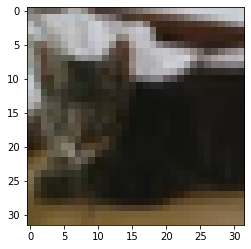

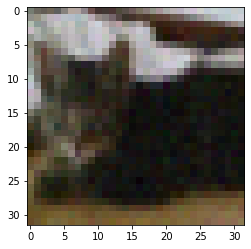

In [17]:
from matplotlib import pyplot as plt

# original image
plt.imshow(tf.reshape(inputs[0,],[3,32,32]).numpy().transpose(1,2,0))
plt.show()
# after adding noise
plt.imshow(tf.reshape(x,[3,32,32]).numpy().transpose(1,2,0))
plt.show()